# Energy Impact Partners
### Training Notebook

1. Imports

1. Importing Datasets

1. Simple XGBoost Implementation

1. 10 Fold Cross-Validation XGBoost Implementation

1. Most Important Features for the XGBoost Algorithm

1. Additional Tuning steps

1. General steps for all ML models

## Imports

In [1]:
#General imports
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Scoring imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

#Model imports
import xgboost as xgb
xgb.set_config(verbosity=0)
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier

#GridsearchCV / BayesearchCV imports
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Pandas Settings
pd.set_option("max_colwidth", 150)
pd.set_option("display.max_columns", 60)
pd.set_option('display.max_rows', None)
# pd.set_option("max_colwidth", 250)

## Importing datasets

In [2]:
# reading ID data from csv
ID = pd.read_csv(r'.\processed data\ID.csv')

# reading X data from csv
X = pd.read_csv(r'.\processed data\X.csv')
x_train = pd.read_csv(r'.\processed data\x_train.csv')
x_test = pd.read_csv(r'.\processed data\x_test.csv')

display(x_test.head(5))


# reading Y data from csv
Y = pd.read_csv(r'.\processed data\Y.csv')
y_train = pd.read_csv(r'.\processed data\y_train.csv')
y_test = pd.read_csv(r'.\processed data\y_test.csv')

,followerCount,employeesOnLinkedIn,Total Raised,# Active Investors,Growth Rate,Growth Rate % Change,Size Multiple,Size Multiple % Change,Top100VCs_count,Top100VCs_dummy,ReceivedEarlyStageFinancing_Dummy,FirstFinancing_Months,LastFinancing_Months,Patent_Dummy,Age,TopAcceleratorList.TopAcceleratorCount,TopStartupList.TopStartupListCount,OpenJobs.1,OpenJobs_Dummy,OpenJobsFTE_ratio,TopUniFTE_count,TopUniFTE_ratio,Primary Industry Group_Agriculture,Primary Industry Group_Capital Markets/Institutions,Primary Industry Group_Chemicals and Gases,Primary Industry Group_Commercial Banks,Primary Industry Group_Commercial Products,Primary Industry Group_Commercial Services,Primary Industry Group_Commercial Transportation,Primary Industry Group_Communications and Networking,...,Primary Industry Group_Energy Equipment,Primary Industry Group_Energy Services,"Primary Industry Group_Exploration, Production and Refining",Primary Industry Group_Healthcare Devices and Supplies,Primary Industry Group_Healthcare Technology Systems,Primary Industry Group_IT Services,Primary Industry Group_Insurance,Primary Industry Group_Media,"Primary Industry Group_Metals, Minerals and Mining",Primary Industry Group_Other Energy,Primary Industry Group_Other Financial Services,Primary Industry Group_Other Materials,Primary Industry Group_Pharmaceuticals and Biotechnology,Primary Industry Group_Retail,Primary Industry Group_Semiconductors,Primary Industry Group_Services (Non-Financial),Primary Industry Group_Software,Primary Industry Group_Textiles,Primary Industry Group_Transportation,Primary Industry Group_Utilities,HQ Global Sub Region_East Asia,HQ Global Sub Region_Eastern Europe,HQ Global Sub Region_Middle East,HQ Global Sub Region_North America,HQ Global Sub Region_Northern Europe,HQ Global Sub Region_Oceania,HQ Global Sub Region_South Asia,HQ Global Sub Region_Southeast Asia,HQ Global Sub Region_Southern Europe,HQ Global Sub Region_Western Europe
0,1406,22.0,2.19,7.0,0.0065,0.0000,1.24,0.0037,2,1,1,5.0,11.0,1,7.0,1,0,NaN,0.0,NaN,13.0,0.448276,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,281,27.0,NaN,NaN,0.0000,0.0000,1.38,-0.0435,0,0,0,NaN,NaN,1,67.0,9,0,NaN,0.0,NaN,0.0,0.000000,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,1899,45.0,6.73,16.0,-0.0047,-0.1535,7.41,-0.0067,0,0,1,NaN,7.0,1,9.0,0,0,2.0,1.0,0.044444,2.0,0.080000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,5344,85.0,10.16,16.0,-0.0013,0.0864,2.92,-0.0407,0,0,0,0.0,NaN,1,7.0,2,1,3.0,1.0,0.035294,17.0,0.309091,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,3487,21.0,5.58,9.0,-0.0220,-0.0024,13.67,0.0034,0,0,0,46.0,5.0,1,8.0,0,0,NaN,0.0,NaN,2.0,0.074074,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


## Removing ID columns for training

In [3]:
# Assuming you're defining a tuple of tuples for parameters
parameters = (
    ('colsample_bylevel', 0.8015579071911014), 
    ('colsample_bytree', 0.44364889457651413),
    ('gamma', 3.811128976537413e-05), 
    ('learning_rate', 0.2700390206185342), 
    ('max_delta_step', 18),
    ('max_depth', 36), 
    ('min_child_weight', 4), 
    ('n_estimators', 100), 
    ('reg_alpha', 1.5057560255472018e-06),
    ('reg_lambda', 659), 
    ('scale_pos_weight', 10), 
    ('subsample', 0.8835665823899177)
)

# Additional parameters as a dictionary (assumed from context)
additional_parameters = {
    'max_depth': 5, 
    'model__learning_rate': 0.2, 
    'model__n_estimators': 1000, 
    'scale_pos_weight': 2
}

# If you are planning to use these in a model setup or similar, ensure they are passed correctly.


## Simple XGB Implementation

In [4]:
%%time
# creating and fitting model
params = {'objective':'binary:logistic', 
          'use_label_encoder': False, 
          'learning_rate': 0.2700390206185342, 
          'min_child_weight': 4, 
          'scale_pos_weight': 8,
          'n_estimators': 100, 
          'max_depth': 36, 
          'max_delta_step': 18,
          'colsample_bytree': 0.44364889457651413, 
          'colsample_bylevel': 0.8015579071911014,
          'subsample': 0.8835665823899177,
          'gamma': 3.811128976537413e-05, 
          'reg_alpha': 1.5057560255472018e-06, 
          'reg_lambda': 659,
         }

model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

y_pred = pd.DataFrame(model.predict(x_test))
Y_pred = pd.DataFrame(model.predict_proba(X))

x_test_with_predictions = pd.concat([x_test, y_pred], axis=1)

Y_X_with_predictions = pd.concat([ID, X, Y, Y_pred], axis=1)

# printing predictions versus groundtruth
#print('y_pred')
#display(y_pred.head(5))
#print('y_test')
#display(y_test.head(5))
#print('x_test_with_predictions')
#display(x_test_with_predictions.head(5))
#print('Y_pred')
#display(Y_pred.head(5))
print('Y_X_with_predictions')
display(Y_X_with_predictions.head(10))

print(f"  Accuracy: {round(accuracy_score(y_test, y_pred),4)*100}%")
print(f"  Precision: {round(precision_score(y_test, y_pred),4)*100}%")
print(f"  Recall: {round(recall_score(y_test, y_pred),4)*100}%")
print(f"  F1-Score: {round(f1_score(y_test, y_pred),4)*100}%")
print(f"  ROC-AUC: {round(roc_auc_score(y_test, y_pred),4)*100}%")

#print(f"  Accuracy: {round(accuracy_score(Y, Y_pred),4)*100}%")
#print(f"  Precision: {round(precision_score(Y, Y_pred),4)*100}%")
#print(f"  Recall: {round(recall_score(Y, Y_pred),4)*100}%")
#print(f"  F1-Score: {round(f1_score(Y, Y_pred),4)*100}%")
#print(f"  ROC-AUC: {round(roc_auc_score(Y, Y_pred),4)*100}%")

cm = confusion_matrix(y_test, y_pred)
print(cm)

print(model)

Y_X_with_predictions


,Affinity Row ID,Organization ID,Name,Organization URL,Pitchbook_ID,followerCount,employeesOnLinkedIn,Total Raised,# Active Investors,Growth Rate,Growth Rate % Change,Size Multiple,Size Multiple % Change,Top100VCs_count,Top100VCs_dummy,ReceivedEarlyStageFinancing_Dummy,FirstFinancing_Months,LastFinancing_Months,Patent_Dummy,Age,TopAcceleratorList.TopAcceleratorCount,TopStartupList.TopStartupListCount,OpenJobs.1,OpenJobs_Dummy,OpenJobsFTE_ratio,TopUniFTE_count,TopUniFTE_ratio,Primary Industry Group_Agriculture,Primary Industry Group_Capital Markets/Institutions,Primary Industry Group_Chemicals and Gases,...,Primary Industry Group_Healthcare Devices and Supplies,Primary Industry Group_Healthcare Technology Systems,Primary Industry Group_IT Services,Primary Industry Group_Insurance,Primary Industry Group_Media,"Primary Industry Group_Metals, Minerals and Mining",Primary Industry Group_Other Energy,Primary Industry Group_Other Financial Services,Primary Industry Group_Other Materials,Primary Industry Group_Pharmaceuticals and Biotechnology,Primary Industry Group_Retail,Primary Industry Group_Semiconductors,Primary Industry Group_Services (Non-Financial),Primary Industry Group_Software,Primary Industry Group_Textiles,Primary Industry Group_Transportation,Primary Industry Group_Utilities,HQ Global Sub Region_East Asia,HQ Global Sub Region_Eastern Europe,HQ Global Sub Region_Middle East,HQ Global Sub Region_North America,HQ Global Sub Region_Northern Europe,HQ Global Sub Region_Oceania,HQ Global Sub Region_South Asia,HQ Global Sub Region_Southeast Asia,HQ Global Sub Region_Southern Europe,HQ Global Sub Region_Western Europe,VC_Next6Months.1,0,1
0,26002779.0,1665719.0,Aircall,aircall.io,81891-91,36528,728.0,193.14,24.0,0.0166,0.2067,37.85,0.0022,2,1,1,0.0,3.0,1,8.0,1,2,237.0,1.0,0.325549,14.0,0.121739,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,0,0.584816,0.415184
1,42222110.0,280864381.0,011h,011h.com,455073-49,6949,55.0,9.56,5.0,-0.0078,0.0000,1.53,0.0226,0,0,0,2.0,17.0,1,2.0,0,1,8.0,1.0,0.145455,5.0,0.108696,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1,0.534915,0.465085
2,26755148.0,122028525.0,InspiraFarms,inspirafarms.com,178919-65,3232,26.0,8.08,9.0,-0.0035,-0.2274,4.65,-0.0147,0,0,0,81.0,24.0,1,10.0,0,0,NaN,0.0,NaN,2.0,0.086957,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0.718265,0.281735
3,35502447.0,282884588.0,1komma5,gerechte1komma5.de,484044-31,4255,43.0,219.86,9.0,0.0301,0.0135,6.48,0.0065,0,0,1,NaN,1.0,1,1.0,0,0,83.0,1.0,1.930233,5.0,0.217391,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,1,0.309121,0.690879
4,44602094.0,1612069.0,Click & Grow,clickandgrow.com,85997-62,2193,36.0,17.76,15.0,-0.0402,-3.4749,7.02,0.0094,1,1,1,14.0,10.0,1,13.0,0,0,1.0,1.0,0.027778,1.0,0.029412,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0,0.760389,0.239611
5,40341385.0,222181321.0,5B Australia,5b.com.au,268631-38,10203,NaN,17.72,9.0,-0.0113,-0.0088,3.03,0.0091,0,0,0,50.0,NaN,1,9.0,0,0,12.0,1.0,NaN,3.0,0.024000,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1,0.508846,0.491154
6,26001792.0,46248228.0,8power,8power.com,163139-32,496,14.0,5.89,14.0,0.0005,0.9956,0.95,0.0127,1,1,1,0.0,6.0,1,7.0,0,1,NaN,0.0,NaN,5.0,0.277778,False,Fal

  Accuracy: 82.36%
  Precision: 7.249999999999999%
  Recall: 8.06%
  F1-Score: 7.630000000000001%
  ROC-AUC: 48.9%
[[560  64]
 [ 57   5]]
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8015579071911014, colsample_bynode=None,
              colsample_bytree=0.44364889457651413, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.811128976537413e-05,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2700390206185342,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=18, max_depth=36, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
CPU times: total: 2.36 s
Wall time: 54

## 10 Fold Cross-Validation XGBoost Implementation

In [5]:
#model = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encoder=False)
#model = RandomForestClassifier()

# setting up iterative imputer and pipeline for model
imputer = IterativeImputer()
pipeline = Pipeline(steps=[
                            #('i', imputer),
                            #('s', StandardScaler()),
                            ('m', model)])

# crossfold validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# evaluating model
scores = cross_val_score(pipeline, X, Y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(f'Overall accuracy of XGBoost with 10 fold-cross validation: {round(np.mean(scores),4)*100}%, std: {round(np.std(scores),3)}')

Overall accuracy of XGBoost with 10 fold-cross validation: 13.77%, std: 0.059


## Most Important Features for the XGBoost Algorithm

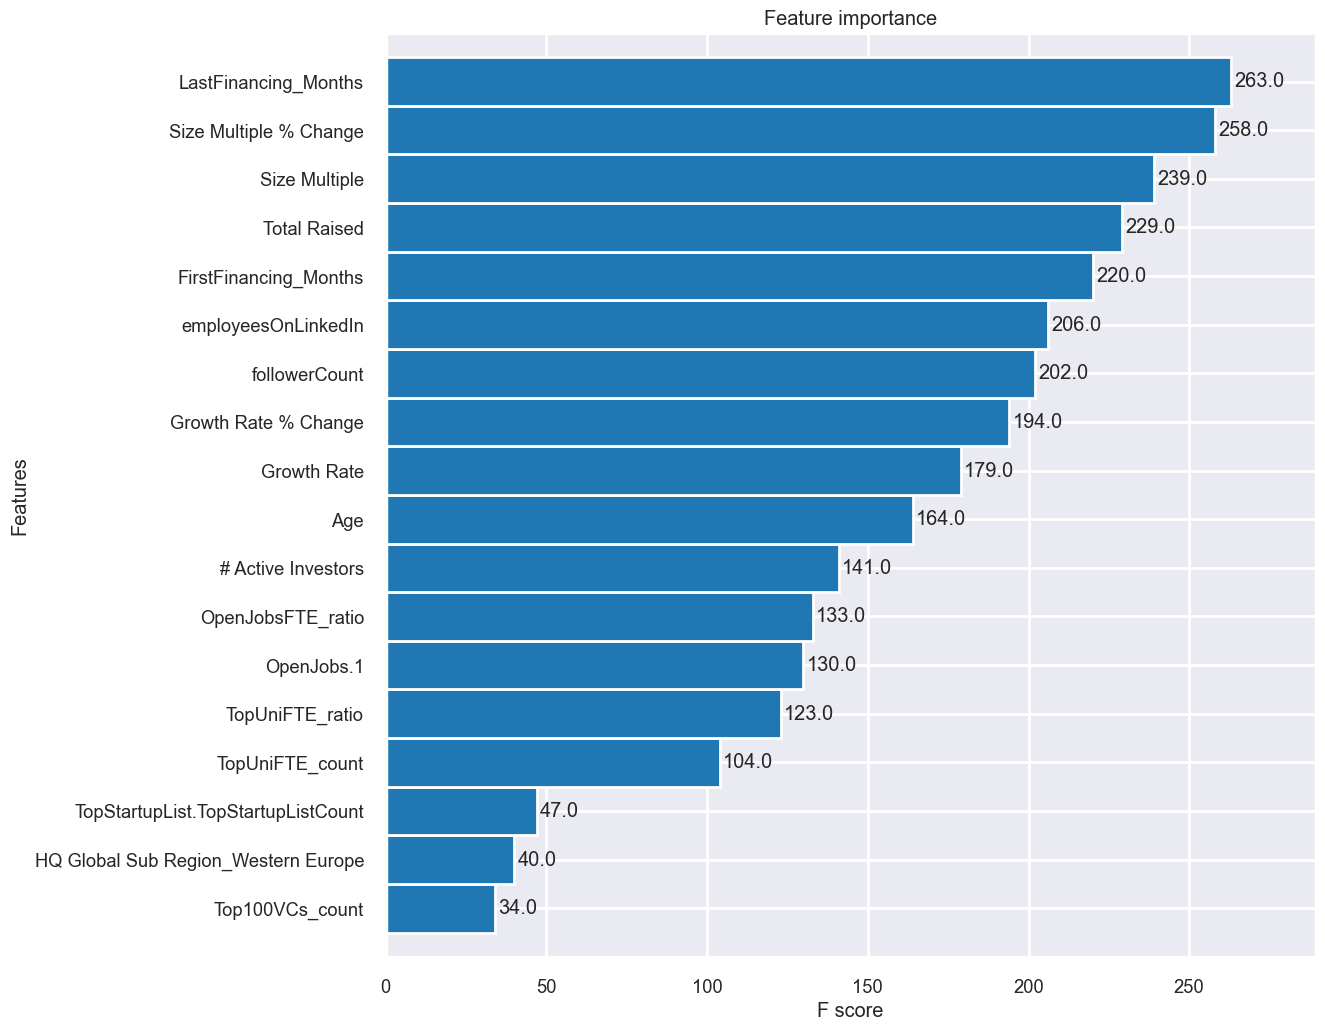

In [6]:
# Section 5: Plot feature importance for the trained model
# Ensure the model used here is the same one fitted in Section 4 and not a new instantiation.

# Set plot style and size
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (12,12)
sns.set_context('poster', font_scale =.6)

# Plot feature importance from the fitted model
plot_importance(model, height =1, max_num_features=18)  # model should be the one fitted in Section 4
plt.show()


# Additional Tuning steps when necessary

## GridsearchCV for XGBoost Alg hyperparameter tuning

In [7]:
%%time

xgb_tuned = GridSearchCV(estimator = model, 
                     param_grid = {'model__learning_rate': [0.2, 0.1, 0.01],
                                   'model__n_estimators': [1000,500, 100],
                                   'max_depth':[5,10,20],
                                   'scale_pos_weight':[2,5,10]},
                                    cv=5,
                                    scoring='precision',
                                    verbose=1,
                                    n_jobs=-1)

xgb_tuned.fit(x_train, y_train)
print(f'highest score: {xgb_tuned.best_score_}, with params: {xgb_tuned.best_params_}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
highest score: 0.17833333333333332, with params: {'max_depth': 10, 'model__learning_rate': 0.2, 'model__n_estimators': 1000, 'scale_pos_weight': 5}
CPU times: total: 3 s
Wall time: 29.5 s


## BayesearchCV for XGBoost Alg hyperparameter tuning

In [8]:
%%time

xgb_tuned = BayesSearchCV(model, {'learning_rate': (0.01, 1.0, 'log-uniform'),
                                  'min_child_weight': (0, 10),
                                  'max_depth': (0, 50),
                                  'max_delta_step': (0, 20),
                                  'subsample': (0.01, 1.0, 'uniform'),
                                  'colsample_bytree': (0.01, 1.0, 'uniform'),
                                  'colsample_bylevel': (0.01, 1.0, 'uniform'),
                                  'reg_lambda': (1e-9, 1000, 'log-uniform'),
                                  'reg_alpha': (1e-9, 1.0, 'log-uniform'),
                                  'gamma': (1e-9, 0.5, 'log-uniform'),
                                  'n_estimators': (50, 100, 1000),
                                  'scale_pos_weight': (1, 5, 10, 20)
                                    },
                                        n_iter=5,
                                        random_state=42,
                                        cv=5,
                                        verbose=1,
                                        scoring='precision',
                                        n_jobs=-1)


xgb_tuned.fit(X,Y)
print(f'highest score: {xgb_tuned.best_score_}, with params: {xgb_tuned.best_params_}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
highest score: 0.1988405797101449, with params: OrderedDict([('colsample_bylevel', 0.8142720284737898), ('colsample_bytree', 0.1801528457825951), ('gamma', 0.00015936523535755285), ('learning_rate', 0.4032083917998946), ('max_delta_step', 10), ('max_depth', 5), ('min_child_weight', 8), ('n_estimators', 1000), ('reg_alpha', 0.1611980387486336), ('reg_lambda', 4.3806965488564525e-05), ('scale_pos_weight', 5), ('subsample', 0.8391548832503206)])
CPU times: total: 7.95 s
Wall time: 12.7 s


## Save predictions to CSV files

In [9]:
# X data to csv
Y_X_with_predictions.to_csv('Y_X_with_predictions.csv', index= False)

## General Steps for all ML models

1. Load in the dataset
2. Explore dataset correlations
3. (sometimes) remove highly correlated features (for speed increase and sometimes accuracy increase)
4. Split Features and target variable into 2 different datasets (X and Y)
5. Train-test-split

6. Imputing values (IterativeImputer()) or imputing by the mean of the column
7. Scale the dataset  ---- MinMax Scaler example -> Feature A max: 100, Feature A min:0 -----> MinMaxScaler(), all values of Feature A / 100 ----> Feature A max: 1, Feature A min: 0
8. Training (.fit(), .predict())
9. Tuning (GridsearchCV)
10. Deployment (get model running on cloud provider such as AWS, so that the model can make predictions at any time on new data sent through the internet)



## Predictions

In [10]:
# Step 1: Read the data
pred = pd.read_excel('./original data/Model1_Apr2022_Data.xlsx')

# Step 2: Separate identification columns
pred_ID = pred[['Affinity Row ID', 'Organization ID', 'Name', 'Organization URL', 'Pitchbook_ID']]

# Step 3: Prepare features for prediction
pred_X = pred.drop(columns=['Affinity Row ID', 'Organization ID', 'Name', 'Organization URL', 'Pitchbook_ID'])
pred_X = pd.get_dummies(pred_X)

# Step 4: Ensure feature consistency with training data
model_features = model.get_booster().feature_names  # Get features used in the model
pred_features = pred_X.columns.tolist()  # Get features in prediction data

# Identify extra and missing features
extra_features = set(pred_features) - set(model_features)
missing_features = set(model_features) - set(pred_features)

# Remove extra features
if extra_features:
    pred_X = pred_X.drop(columns=extra_features)

# Add missing features with default values (e.g., 0)
for feature in missing_features:
    pred_X[feature] = 0

# Ensure column order matches
pred_X = pred_X[model_features]

# Step 5: Make predictions
pred_Y = pd.DataFrame(model.predict_proba(pred_X))

# Step 6: Combine predictions with IDs and features
predictions = pd.concat([pred_ID, pred_X, pred_Y], axis=1)

# Step 7: Display and save predictions
display(predictions.head(10))
predictions.to_csv('Sep2022_Model1_Predictions_final.csv', index=False)

,Affinity Row ID,Organization ID,Name,Organization URL,Pitchbook_ID,followerCount,employeesOnLinkedIn,Total Raised,# Active Investors,Growth Rate,Growth Rate % Change,Size Multiple,Size Multiple % Change,Top100VCs_count,Top100VCs_dummy,ReceivedEarlyStageFinancing_Dummy,FirstFinancing_Months,LastFinancing_Months,Patent_Dummy,Age,TopAcceleratorList.TopAcceleratorCount,TopStartupList.TopStartupListCount,OpenJobs.1,OpenJobs_Dummy,OpenJobsFTE_ratio,TopUniFTE_count,TopUniFTE_ratio,Primary Industry Group_Agriculture,Primary Industry Group_Capital Markets/Institutions,Primary Industry Group_Chemicals and Gases,...,"Primary Industry Group_Exploration, Production and Refining",Primary Industry Group_Healthcare Devices and Supplies,Primary Industry Group_Healthcare Technology Systems,Primary Industry Group_IT Services,Primary Industry Group_Insurance,Primary Industry Group_Media,"Primary Industry Group_Metals, Minerals and Mining",Primary Industry Group_Other Energy,Primary Industry Group_Other Financial Services,Primary Industry Group_Other Materials,Primary Industry Group_Pharmaceuticals and Biotechnology,Primary Industry Group_Retail,Primary Industry Group_Semiconductors,Primary Industry Group_Services (Non-Financial),Primary Industry Group_Software,Primary Industry Group_Textiles,Primary Industry Group_Transportation,Primary Industry Group_Utilities,HQ Global Sub Region_East Asia,HQ Global Sub Region_Eastern Europe,HQ Global Sub Region_Middle East,HQ Global Sub Region_North America,HQ Global Sub Region_Northern Europe,HQ Global Sub Region_Oceania,HQ Global Sub Region_South Asia,HQ Global Sub Region_Southeast Asia,HQ Global Sub Region_Southern Europe,HQ Global Sub Region_Western Europe,0,1
0,26002779.0,1665719.0,Aircall,aircall.io,81891-91,36528,728.0,193.14,24.0,0.0166,0.2067,37.85,0.0022,2,1,1,0.0,3.0,1,8.0,1,2,237.0,1.0,0.325549,14.0,0.121739,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,0.584816,0.415184
1,42222110.0,280864381.0,011h,011h.com,455073-49,6949,55.0,9.56,5.0,-0.0078,0.0000,1.53,0.0226,0,0,0,2.0,17.0,1,2.0,0,1,8.0,1.0,0.145455,5.0,0.108696,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.534915,0.465085
2,26755148.0,122028525.0,InspiraFarms,inspirafarms.com,178919-65,3232,26.0,8.08,9.0,-0.0035,-0.2274,4.65,-0.0147,0,0,0,81.0,24.0,1,10.0,0,0,NaN,0.0,NaN,2.0,0.086957,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.718265,0.281735
3,35502447.0,282884588.0,1komma5,gerechte1komma5.de,484044-31,4255,43.0,219.86,9.0,0.0301,0.0135,6.48,0.0065,0,0,1,NaN,1.0,1,1.0,0,0,83.0,1.0,1.930233,5.0,0.217391,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.309121,0.690879
4,44602094.0,1612069.0,Click & Grow,clickandgrow.com,85997-62,2193,36.0,17.76,15.0,-0.0402,-3.4749,7.02,0.0094,1,1,1,14.0,10.0,1,13.0,0,0,1.0,1.0,0.027778,1.0,0.029412,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0.760389,0.239611
5,40341385.0,222181321.0,5B Australia,5b.com.au,268631-38,10203,NaN,17.72,9.0,-0.0113,-0.0088,3.03,0.0091,0,0,0,50.0,NaN,1,9.0,0,0,12.0,1.0,NaN,3.0,0.024000,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0.508846,0.491154
6,26001792.0,46248228.0,8power,8power.com,163139-32,496,14.0,5.89,14.0,0.0005,0.9956,0

In [11]:
#train = pd.read_excel('./original data/Model1_Test4_May2021_Data.xlsx')

display(pred_X.head(10))

display(X.head(10))

,followerCount,employeesOnLinkedIn,Total Raised,# Active Investors,Growth Rate,Growth Rate % Change,Size Multiple,Size Multiple % Change,Top100VCs_count,Top100VCs_dummy,ReceivedEarlyStageFinancing_Dummy,FirstFinancing_Months,LastFinancing_Months,Patent_Dummy,Age,TopAcceleratorList.TopAcceleratorCount,TopStartupList.TopStartupListCount,OpenJobs.1,OpenJobs_Dummy,OpenJobsFTE_ratio,TopUniFTE_count,TopUniFTE_ratio,Primary Industry Group_Agriculture,Primary Industry Group_Capital Markets/Institutions,Primary Industry Group_Chemicals and Gases,Primary Industry Group_Commercial Banks,Primary Industry Group_Commercial Products,Primary Industry Group_Commercial Services,Primary Industry Group_Commercial Transportation,Primary Industry Group_Communications and Networking,...,Primary Industry Group_Energy Equipment,Primary Industry Group_Energy Services,"Primary Industry Group_Exploration, Production and Refining",Primary Industry Group_Healthcare Devices and Supplies,Primary Industry Group_Healthcare Technology Systems,Primary Industry Group_IT Services,Primary Industry Group_Insurance,Primary Industry Group_Media,"Primary Industry Group_Metals, Minerals and Mining",Primary Industry Group_Other Energy,Primary Industry Group_Other Financial Services,Primary Industry Group_Other Materials,Primary Industry Group_Pharmaceuticals and Biotechnology,Primary Industry Group_Retail,Primary Industry Group_Semiconductors,Primary Industry Group_Services (Non-Financial),Primary Industry Group_Software,Primary Industry Group_Textiles,Primary Industry Group_Transportation,Primary Industry Group_Utilities,HQ Global Sub Region_East Asia,HQ Global Sub Region_Eastern Europe,HQ Global Sub Region_Middle East,HQ Global Sub Region_North America,HQ Global Sub Region_Northern Europe,HQ Global Sub Region_Oceania,HQ Global Sub Region_South Asia,HQ Global Sub Region_Southeast Asia,HQ Global Sub Region_Southern Europe,HQ Global Sub Region_Western Europe
0,36528,728.0,193.14,24.0,0.0166,0.2067,37.85,0.0022,2,1,1,0.0,3.0,1,8.0,1,2,237.0,1.0,0.325549,14.0,0.121739,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
1,6949,55.0,9.56,5.0,-0.0078,0.0000,1.53,0.0226,0,0,0,2.0,17.0,1,2.0,0,1,8.0,1.0,0.145455,5.0,0.108696,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3232,26.0,8.08,9.0,-0.0035,-0.2274,4.65,-0.0147,0,0,0,81.0,24.0,1,10.0,0,0,NaN,0.0,NaN,2.0,0.086957,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,4255,43.0,219.86,9.0,0.0301,0.0135,6.48,0.0065,0,0,1,NaN,1.0,1,1.0,0,0,83.0,1.0,1.930233,5.0,0.217391,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,2193,36.0,17.76,15.0,-0.0402,-3.4749,7.02,0.0094,1,1,1,14.0,10.0,1,13.0,0,0,1.0,1.0,0.027778,1.0,0.029412,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5,10203,NaN,17.72,9.0,-0.0113,-0.0088,3.03,0.0091,0,0,0,50.0,NaN,1,9.0,0,0,12.0,1.0,NaN,3.0,0.024000,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,496,14.0,5.89,14.0,0.0005,0.9956,0.95,0.012

,followerCount,employeesOnLinkedIn,Total Raised,# Active Investors,Growth Rate,Growth Rate % Change,Size Multiple,Size Multiple % Change,Top100VCs_count,Top100VCs_dummy,ReceivedEarlyStageFinancing_Dummy,FirstFinancing_Months,LastFinancing_Months,Patent_Dummy,Age,TopAcceleratorList.TopAcceleratorCount,TopStartupList.TopStartupListCount,OpenJobs.1,OpenJobs_Dummy,OpenJobsFTE_ratio,TopUniFTE_count,TopUniFTE_ratio,Primary Industry Group_Agriculture,Primary Industry Group_Capital Markets/Institutions,Primary Industry Group_Chemicals and Gases,Primary Industry Group_Commercial Banks,Primary Industry Group_Commercial Products,Primary Industry Group_Commercial Services,Primary Industry Group_Commercial Transportation,Primary Industry Group_Communications and Networking,...,Primary Industry Group_Energy Equipment,Primary Industry Group_Energy Services,"Primary Industry Group_Exploration, Production and Refining",Primary Industry Group_Healthcare Devices and Supplies,Primary Industry Group_Healthcare Technology Systems,Primary Industry Group_IT Services,Primary Industry Group_Insurance,Primary Industry Group_Media,"Primary Industry Group_Metals, Minerals and Mining",Primary Industry Group_Other Energy,Primary Industry Group_Other Financial Services,Primary Industry Group_Other Materials,Primary Industry Group_Pharmaceuticals and Biotechnology,Primary Industry Group_Retail,Primary Industry Group_Semiconductors,Primary Industry Group_Services (Non-Financial),Primary Industry Group_Software,Primary Industry Group_Textiles,Primary Industry Group_Transportation,Primary Industry Group_Utilities,HQ Global Sub Region_East Asia,HQ Global Sub Region_Eastern Europe,HQ Global Sub Region_Middle East,HQ Global Sub Region_North America,HQ Global Sub Region_Northern Europe,HQ Global Sub Region_Oceania,HQ Global Sub Region_South Asia,HQ Global Sub Region_Southeast Asia,HQ Global Sub Region_Southern Europe,HQ Global Sub Region_Western Europe
0,36528,728.0,193.14,24.0,0.0166,0.2067,37.85,0.0022,2,1,1,0.0,3.0,1,8.0,1,2,237.0,1.0,0.325549,14.0,0.121739,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
1,6949,55.0,9.56,5.0,-0.0078,0.0000,1.53,0.0226,0,0,0,2.0,17.0,1,2.0,0,1,8.0,1.0,0.145455,5.0,0.108696,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3232,26.0,8.08,9.0,-0.0035,-0.2274,4.65,-0.0147,0,0,0,81.0,24.0,1,10.0,0,0,NaN,0.0,NaN,2.0,0.086957,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,4255,43.0,219.86,9.0,0.0301,0.0135,6.48,0.0065,0,0,1,NaN,1.0,1,1.0,0,0,83.0,1.0,1.930233,5.0,0.217391,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,2193,36.0,17.76,15.0,-0.0402,-3.4749,7.02,0.0094,1,1,1,14.0,10.0,1,13.0,0,0,1.0,1.0,0.027778,1.0,0.029412,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5,10203,NaN,17.72,9.0,-0.0113,-0.0088,3.03,0.0091,0,0,0,50.0,NaN,1,9.0,0,0,12.0,1.0,NaN,3.0,0.024000,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,496,14.0,5.89,14.0,0.0005,0.9956,0.95,0.012